# 폐렴을 진단하자.

## 0. 모듈 import

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## 1. 실험환경 Set-up

이번에 사용할 데이터는 캐글의 Chest X-Ray Images 이다.  
출저 : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

앞으로 사용할 변수들을 미리 생성하자.

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 30

print(ROOT_PATH)

/aiffel/aiffel


## 2. 데이터 준비하기

준비된 데이터를 수를 확인해보자.

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


validation 파일수가 16개로 너무 적으므로,  
학습데이터와 합쳐서 새롭게 나우어 주자.

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(f'총 데이터 개수 : {len(filenames)}')
print(f'총 학습 데이터 개수 : {len(train_filenames)}')
print(f'총 검증 데이터 개수 : {len(val_filenames)}')

총 데이터 개수 : 5232
총 학습 데이터 개수 : 4185
총 검증 데이터 개수 : 1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[-1]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1231_virus_2088.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person942_bacteria_2867.jpeg


현재 이미지 파일들은 따로 라벨링 없이 나눠진 폴더로 구분되어 있다.  
라벨링된 데이터를 확인해보자.

In [6]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1349
Pneumonia images count in training set: 3883


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### 데이터 불러오기 및 라벨링

이제 각 파일주소의 이미지를 불러와서 라벨을 붙여준다.  
이미지의 크기는 위에서 설정한 대로 180 * 180으로 불러온다.

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [10]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [12]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### 데이터 증강 및 데이터셋 구성

학습시의 과적합을 방지하기 위해서 batch normalization이나 drop out을 고려할 수 있지만,  
좋은 방법은 다량의 데이터로 학습시키는 것이다.  
다만, 이런 의료 이미지나 제한된 데이터의 경우 데이터를 구하기 쉽지 않기 때문에  
데이터 augmentation 기법을 이용해서 데이터를 추가해 볼 것이다.

여러 augmentation 기법을 고려해 볼 수 있지만 의료 영상인 경우,  
일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없다.   
일단 이미지가 모두 정방향이기 때문에 회전하면 오리혀 성능이 떨어질 수도 있다.

일단 이미지의 반전, 채도 변경정도만 구현해보자.

In [13]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds_base = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    
    return image,label

def prepare_for_training_flip(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_flip = prepare_for_training_flip(train_ds)

In [15]:
def augment(image,label):
    image = tf.image.random_saturation(image, 0, 5)  # 랜덤하게 채도 변경
    
    return image,label

def prepare_for_training_saturation(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_saturation = prepare_for_training_saturation(train_ds)

## 3. 데이터 시각화

위에서 만든 3개의 데이터 셋을 각각 시각화시켜보자.

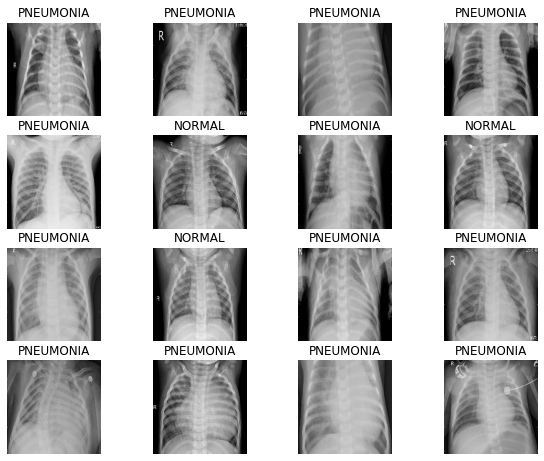

In [17]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds_base))
show_batch(image_batch.numpy(), label_batch.numpy())

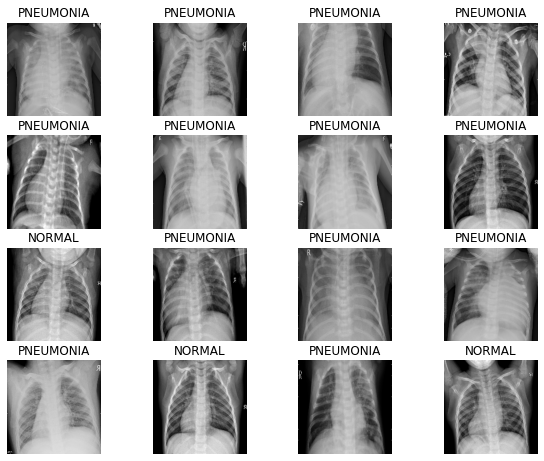

In [18]:
image_batch, label_batch = next(iter(train_ds_flip))
show_batch(image_batch.numpy(), label_batch.numpy())

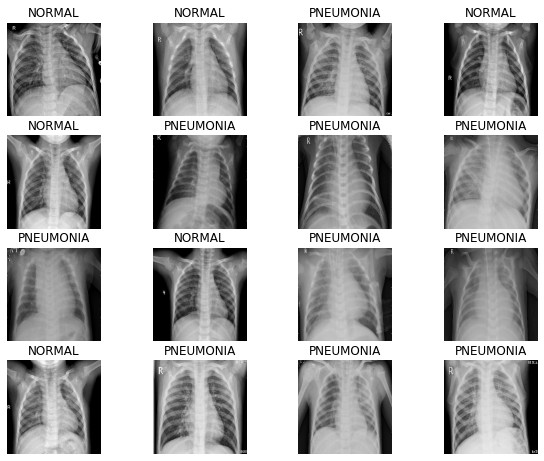

In [19]:
image_batch, label_batch = next(iter(train_ds_saturation))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4. CNN 모델링

regularization 을 할 때, batch normalization만 사용한 경우와  
dropout을 같이 사용한 경우를 나눠서 모델을 만들어보자.

In [20]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [21]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [22]:
def dense_block2(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
    ])
    
    return block

In [23]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [24]:
def build_model2():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        
        conv_block(256),
        
        tf.keras.layers.Flatten(),
        dense_block2(512, 0.7),
        dense_block2(128, 0.5),
        dense_block2(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalance 처리

In [25]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.55
Weight for PNEUMONIA: 0.54


## 6. 모델 훈련

In [26]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

데이터 증강 없이 모델을 돌렸을 경우

In [27]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_base,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
261/261 [==============================] - 57s 141ms/step - loss: 0.4930 - accuracy: 0.6639 - precision: 0.8852 - recall: 0.6240 - val_loss: 0.6274 - val_accuracy: 0.7231 - val_precision: 0.7231 - val_recall: 1.0000
Epoch 2/30
261/261 [==============================] - 36s 137ms/step - loss: 0.2034 - accuracy: 0.8946 - precision: 0.9718 - recall: 0.8851 - val_loss: 1.3028 - val_accuracy: 0.7231 - val_precision: 0.7231 - val_recall: 1.0000
Epoch 3/30
261/261 [==============================] - 36s 136ms/step - loss: 0.1917 - accuracy: 0.9111 - precision: 0.9749 - recall: 0.9067 - val_loss: 0.5324 - val_accuracy: 0.7510 - val_precision: 0.7441 - val_recall: 1.0000
Epoch 4/30
261/261 [==============================] - 36s 138ms/step - loss: 0.1504 - accuracy: 0.9283 - precision: 0.9778 - recall: 0.9245 - val_loss: 0.1122 - val_accuracy: 0.9625 - val_precision: 0.9917 - val_recall: 0.9561
Epoch 5/30
261/261 [==============================] - 36s 137ms/step - loss: 0.1233 - accura

데이터 증강을 한 데이터셋으로 학습하는 경우

In [30]:
with tf.device('/GPU:0'):
    history_flip = model.fit(
        train_ds_flip,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
261/261 [==============================] - 40s 137ms/step - loss: 0.0782 - accuracy: 0.9638 - precision: 0.9888 - recall: 0.9625 - val_loss: 0.1589 - val_accuracy: 0.9471 - val_precision: 0.9330 - val_recall: 0.9987
Epoch 2/30
261/261 [==============================] - 36s 136ms/step - loss: 0.0834 - accuracy: 0.9612 - precision: 0.9891 - recall: 0.9586 - val_loss: 0.0531 - val_accuracy: 0.9760 - val_precision: 0.9789 - val_recall: 0.9880
Epoch 3/30
261/261 [==============================] - 35s 136ms/step - loss: 0.0808 - accuracy: 0.9658 - precision: 0.9921 - recall: 0.9619 - val_loss: 0.0617 - val_accuracy: 0.9769 - val_precision: 0.9946 - val_recall: 0.9734
Epoch 4/30
261/261 [==============================] - 35s 136ms/step - loss: 0.0724 - accuracy: 0.9672 - precision: 0.9917 - recall: 0.9640 - val_loss: 0.1591 - val_accuracy: 0.9462 - val_precision: 0.9317 - val_recall: 0.9987
Epoch 5/30
261/261 [==============================] - 36s 137ms/step - loss: 0.0577 - accura

KeyboardInterrupt: 

##  7. 결과 확인과 시각화

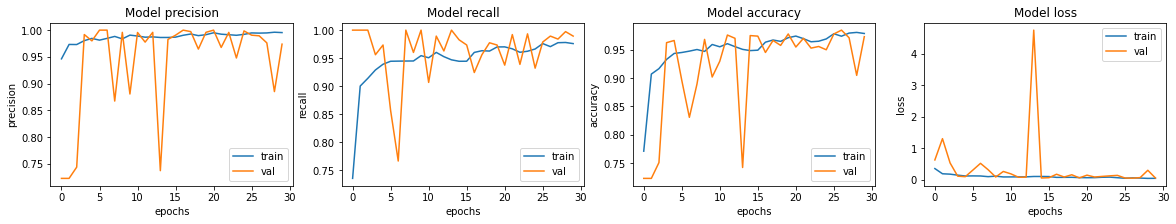

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [29]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 74ms/step - loss: 1.4480 - accuracy: 0.7484 - precision: 0.7138 - recall: 0.9974
Loss: 1.4480422735214233,
Accuracy: 0.7483974099159241,
Precision: 0.7137614488601685,
Recall: 0.9974358677864075


In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_flip.history[met])
    ax[i].plot(history_flip.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

## 8. 회고

x-ray 이미지에서 폐렴 유무를 판단하는 모델을 만들어 보았다.

이번 프로젝트의 중요한 점 중 하나가 data augmentation 이었는데,  
시간이 없어서 여러가지를 적용해보지 못하였다.